In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from pprint import pprint
%matplotlib inline
import seaborn as sns

import googlemaps

## Imput API Key to Google Maps

In [2]:
api_key = open('google_api_key.txt','r')
gmaps = googlemaps.Client(key=api_key.readline())
api_key.close()

## Read in CSV

In [110]:
df = pd.read_csv('personal_apartment_list.csv')
df = df.ffill()

df['priceSquareFoot'] = df.price / df.squareFootage

#df = df.astype({'covered_parking':'bool', 'balcony':'bool', 'washer_dryer':'bool','loft':'bool'})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          30 non-null     object 
 1   bedrooms         30 non-null     int64  
 2   bathrooms        30 non-null     float64
 3   price            30 non-null     int64  
 4   squareFootage    30 non-null     int64  
 5   floorplan        30 non-null     object 
 6   complex          30 non-null     object 
 7   covered_parking  30 non-null     float64
 8   balcony          30 non-null     int64  
 9   washer_dryer     30 non-null     int64  
 10  loft             30 non-null     int64  
 11  hardwood_floors  30 non-null     int64  
 12  office           30 non-null     int64  
 13  open_concept     30 non-null     int64  
 14  high_ceiling     30 non-null     int64  
 15  priceSquareFoot  30 non-null     float64
dtypes: float64(3), int64(10), object(3)
memory usage: 3.9+ KB


In [111]:
complex_address = df.address.unique()

len(complex_address)

8

In [112]:
%%time
latitude = {}
longitude = {}

for address in complex_address:
    geocode_result = gmaps.geocode(address)
    geocode = geocode_result[0]['geometry']['location']
    latitude[address] = geocode['lat']
    longitude[address] = geocode['lng']
    
Lat = []
Long = []
for i, row in df.iterrows():
    Lat.append(latitude[row.address])
    Long.append(longitude[row.address])
    
df['latitude'] = Lat
df['longitude'] = Long

df.head()

Wall time: 4.04 s


,address,bedrooms,bathrooms,price,squareFootage,floorplan,complex,covered_parking,balcony,washer_dryer,loft,hardwood_floors,office,open_concept,high_ceiling,priceSquareFoot,latitude,longitude
0,"5600 Columbia Pike, Falls Church, VA 22041",1,1.0,1837,962,Inspire,Mission Lofts,1.0,0,1,0,1,0,1,1,1.909563,38.853992,-77.123056
1,"5600 Columbia Pike, Falls Church, VA 22041",2,1.0,2378,1083,Objective,Mission Lofts,1.0,0,1,0,1,0,1,1,2.195753,38.853992,-77.123056
2,"5600 Columbia Pike, Falls Church, VA 22041",2,2.5,2387,1092,Purpose,Mission Lofts,1.0,0,1,0,1,0,1,1,2.185897,38.853992,-77.123056
3,"5600 Columbia Pike, Falls Church, VA 22041",1,1.0,1803,720,Aspire,Mission Lofts,1.0,1,1,0,1,0,1,1,2.504167,38.853992,-77.123056
4,"4501 Ford Ave, Alexandria, VA 22302",1,1.0,1724,632,6C,E-Lofts,1.0,0,1,0,1,0,1,1,2.727848,38.837194,-77.105277


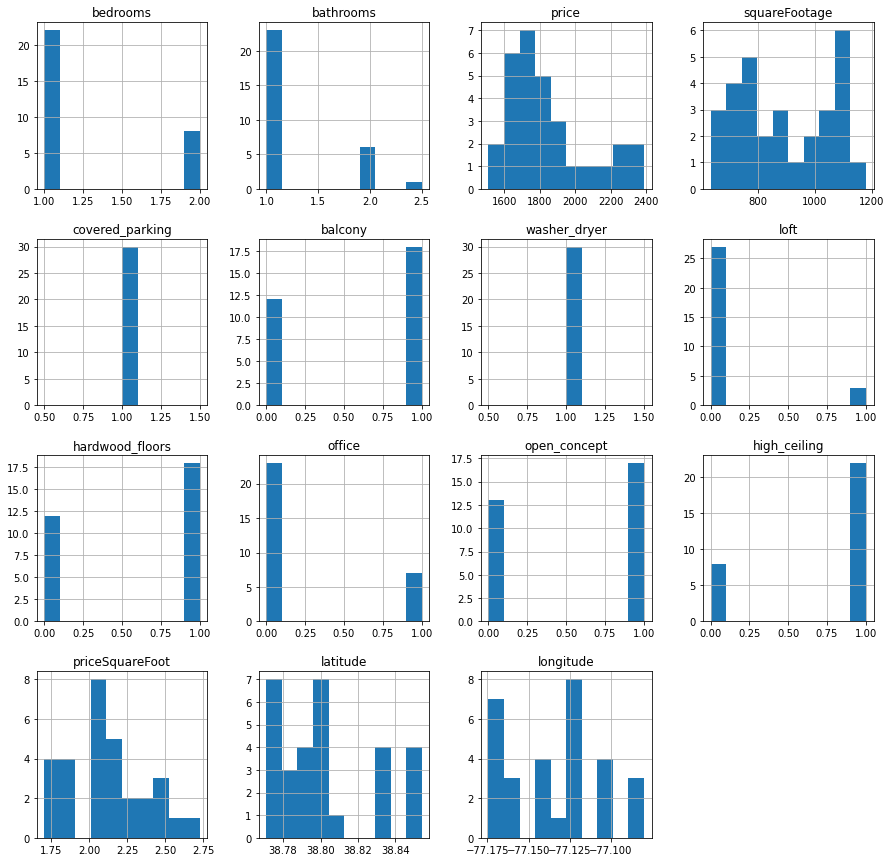

In [113]:
ax_list = df.hist(bins=10, figsize=(15,15))

## Calulate the Commute Time

In [114]:
arrive =datetime(2021, 5, 18, 7, 30, 0)
print(arrive)

2021-05-18 07:30:00


In [115]:
%%time

commute = {}

for address in complex_address:
    Origin = address
    Destination = '7500 GEOINT Dr, Springfield, VA 22150'
    
    results = gmaps.distance_matrix(Origin,
                                    Destination, 
                                    mode='driving', 
                                    arrival_time=arrive)
    
    commute[address] = results['rows'][0]['elements'][0]['duration']['text']
    
commute

Wall time: 3.65 s


{'5600 Columbia Pike, Falls Church, VA 22041': '19 mins',
 '4501 Ford Ave, Alexandria, VA 22302': '16 mins',
 '6802 Junction Blvd, Springfield, VA 22150': '8 mins',
 '6200 N Kings Hwy, Alexandria, VA 22303': '21 mins',
 '5000 Eisenhower Ave, Alexandria, VA 22304': '13 mins',
 '6001 Archstone Way, Alexandria, VA 22310': '15 mins',
 '5760 Dow Ave, Alexandria, VA 22304': '16 mins',
 '5575 Vincent Gate Terrace, Alexandria, VA': '12 mins'}

In [116]:
commute_time = []

for i, row in df.iterrows():
    commute_time.append(commute[row.address].split(' ')[0])
    
df['commute_time'] = commute_time

df = df.astype({'commute_time':'int64'})

## Count the Number of Entities with 2km of the Complex
We are specifically looking for the number of:
<ul>
    <li>Grocery Stores</li>
    <li>Bars</li>
    <li>Gas Stations</li>
    <li>Restaurants</li>
    <li>Hospitals within 1km </li>
    <li>Parks</li>
</ul>

In [117]:
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

In [118]:
%%time

grocery = {}
bars = {}
gas = {}
resturants = {}
hospitals = {}
parks = {}

for address in complex_address:
    location = (latitude[address],longitude[address])
    gr = gmaps.places(query='grocery store', location=location, radius=500, type='supermarket')
    ba = gmaps.places(query='bar', location=location, radius=500)
    ga = gmaps.places(query='gas station', location=location, radius=500)
    re = gmaps.places(query='resturant', location=location, radius=500)
    ho = gmaps.places(query='hospitals', location=location, radius=500)
    pa = gmaps.places(query='parks', location=location, radius=500)
    
    gr_count = 0
    for x in gr['results']:
        gr_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], gr_location['lat'],gr_location['lng']) < 2:
            gr_count +=1
            
    ba_count = 0
    for x in ba['results']:
        ba_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], ba_location['lat'],ba_location['lng']) < 2:
            ba_count +=1
    
    ga_count = 0
    for x in ga['results']:
        ga_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], ga_location['lat'],ga_location['lng']) < 2:
            ga_count +=1
            
    re_count = 0
    for x in re['results']:
        re_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], re_location['lat'],re_location['lng']) < 2:
            re_count +=1
            
    ho_count = 0
    for x in ho['results']:
        ho_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], ho_location['lat'],ho_location['lng']) < 2:
            ho_count +=1
            
    pa_count = 0
    for x in pa['results']:
        pa_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], pa_location['lat'],pa_location['lng']) < 2:
            pa_count +=1
            
    
    grocery[address] = gr_count
    bars[address] = ba_count
    gas[address] = ga_count
    resturants[address] = re_count
    hospitals[address] = ho_count
    parks[address] = pa_count

Wall time: 1min


In [119]:
grocery_count = []
bar_count = []
gas_count = []
resturant_count = []
hospital_count = []
park_count = []

for i, row in df.iterrows():
    grocery_count.append(grocery[row.address])
    bar_count.append(bars[row.address])
    gas_count.append(gas[row.address])
    resturant_count.append(resturants[row.address])
    hospital_count.append(hospitals[row.address])
    park_count.append(parks[row.address])
    
df['grocery_count'] = grocery_count
df['bar_count'] = bar_count
df['gas_count'] = gas_count
df['resturant_count'] = resturant_count
df['hospital_count'] = hospital_count
df['park_count'] = park_count

In [120]:
df.describe().round(3)

,bedrooms,bathrooms,price,squareFootage,covered_parking,balcony,washer_dryer,loft,hardwood_floors,office,...,priceSquareFoot,latitude,longitude,commute_time,grocery_count,bar_count,gas_count,resturant_count,hospital_count,park_count
count,30.000,30.000,30.000,30.000,30.0,30.000,30.0,30.000,30.000,30.000,...,30.000,30.000,30.000,30.00,30.000,30.000,30.000,30.000,30.000,30.000
mean,1.267,1.250,1844.533,882.667,1.0,0.600,1.0,0.100,0.600,0.233,...,2.128,38.803,-77.135,14.10,5.767,8.100,8.267,13.067,0.500,8.300
std,0.450,0.469,240.005,170.784,0.0,0.498,0.0,0.305,0.498,0.430,...,0.267,0.029,0.030,4.31,2.555,4.964,3.483,4.226,0.731,4.632
min,1.000,1.000,1510.000,632.000,1.0,0.000,1.0,0.000,0.000,0.000,...,1.706,38.771,-77.174,8.00,0.000,0.000,4.000,4.000,0.000,3.000
25%,1.000,1.000,1694.750,743.250,1.0,0.000,1.0,0.000,0.000,0.000,...,1.936,38.784,-77.161,12.00,5.000,5.000,5.000,12.000,0.000,4.000
50%,1.000,1.000,1770.000,862.000,1.0,1.000,1.0,0.000,1.000,0.000,...,2.107,38.801,-77.128,15.00,6.000,9.000,8.000,14.000,0.000,6.000
75%,1.750,1.000,1925.000,1057.250,1.0,1.000,1.0,0.000,1.000,0.000,...,2.273,38.829,-77.123,16.00,7.750,10.000,11.000,16.750,1.000,13.750
max,2.000,2.500,2387.000,1179.000,1.0,1.000,1.0,1.000,1.000,1.000,...,2.728,38.854,-77.080,21.00,9.000,15.000,14.000,17.000,2.000,14.000


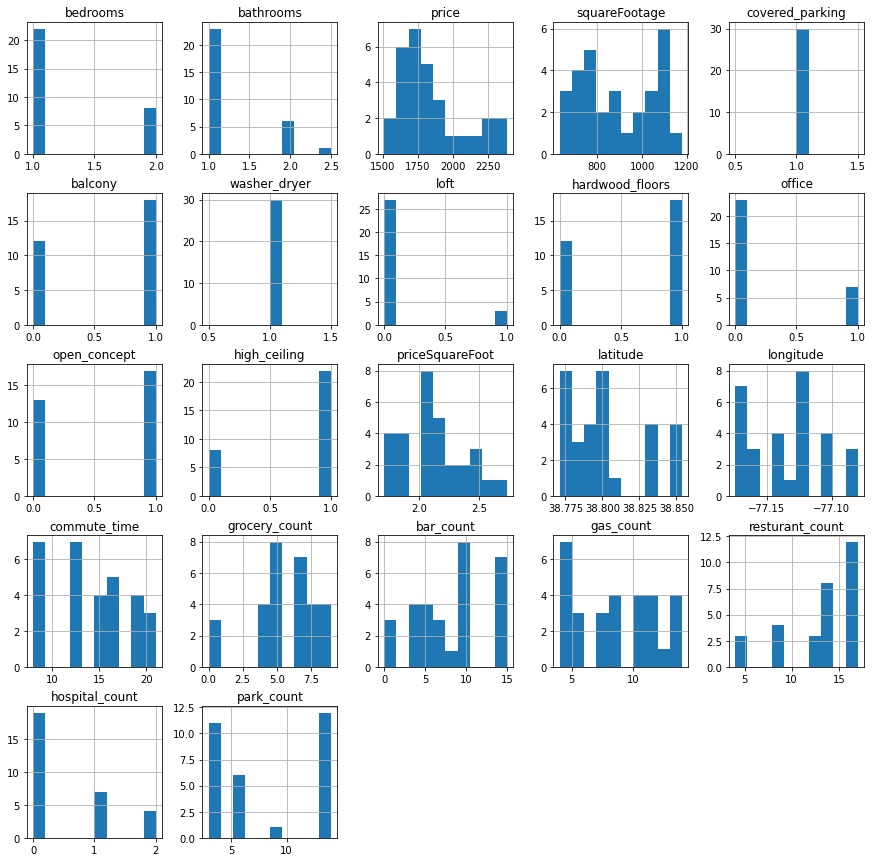

In [121]:
ax_list = df.hist(bins=10, figsize=(15,15))

## Score the Apartments

In [122]:
def set_score(row):
    score = (row['price']*-1.5 + 
             row['bedrooms']+ 
             row['bathrooms'] + 
             row['squareFootage']*1.5 + #I want a large apartment
             row['covered_parking']*2 + 
             row['commute_time']*-4 +  #I go to the office 4 days a week
             row['grocery_count'] +
             row['bar_count']*.5 +
             row['gas_count'] +
             row['resturant_count'] +
             row['hospital_count']*-2 + #Penalize for sound
             row['park_count']*2 +
             row['hardwood_floors']+
             row['open_concept'] +
             row['high_ceiling']*.5 +
             row['office']*2
            )
             
    return score

In [123]:
%%time
df['scores'] = df.apply(set_score, axis=1)

Wall time: 2.99 ms


In [124]:
df.describe().round(3)

,bedrooms,bathrooms,price,squareFootage,covered_parking,balcony,washer_dryer,loft,hardwood_floors,office,...,latitude,longitude,commute_time,grocery_count,bar_count,gas_count,resturant_count,hospital_count,park_count,scores
count,30.000,30.000,30.000,30.000,30.0,30.000,30.0,30.000,30.000,30.000,...,30.000,30.000,30.00,30.000,30.000,30.000,30.000,30.000,30.000,30.000
mean,1.267,1.250,1844.533,882.667,1.0,0.600,1.0,0.100,0.600,0.233,...,38.803,-77.135,14.10,5.767,8.100,8.267,13.067,0.500,8.300,-1445.933
std,0.450,0.469,240.005,170.784,0.0,0.498,0.0,0.305,0.498,0.430,...,0.029,0.030,4.31,2.555,4.964,3.483,4.226,0.731,4.632,230.310
min,1.000,1.000,1510.000,632.000,1.0,0.000,1.0,0.000,0.000,0.000,...,38.771,-77.174,8.00,0.000,0.000,4.000,4.000,0.000,3.000,-1941.000
25%,1.000,1.000,1694.750,743.250,1.0,0.000,1.0,0.000,0.000,0.000,...,38.784,-77.161,12.00,5.000,5.000,5.000,12.000,0.000,4.000,-1617.750
50%,1.000,1.000,1770.000,862.000,1.0,1.000,1.0,0.000,1.000,0.000,...,38.801,-77.128,15.00,6.000,9.000,8.000,14.000,0.000,6.000,-1439.000
75%,1.750,1.000,1925.000,1057.250,1.0,1.000,1.0,0.000,1.000,0.000,...,38.829,-77.123,16.00,7.750,10.000,11.000,16.750,1.000,13.750,-1304.875
max,2.000,2.500,2387.000,1179.000,1.0,1.000,1.0,1.000,1.000,1.000,...,38.854,-77.080,21.00,9.000,15.000,14.000,17.000,2.000,14.000,-1098.500


C:\Users\Callie\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='scores', ylabel='Density'>

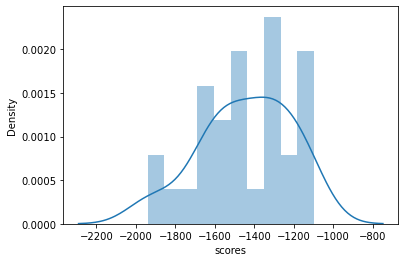

In [125]:
sns.distplot(df['scores'], bins=10)

C:\Users\Callie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


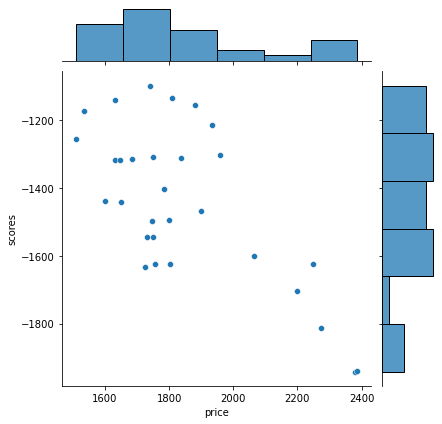

In [126]:
sns.jointplot('price','scores',data=df)

In [127]:
df.to_csv('data/apartment_scores_unscaled.csv')

## Scale the Data

In [128]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          30 non-null     object 
 1   bedrooms         30 non-null     int64  
 2   bathrooms        30 non-null     float64
 3   price            30 non-null     int64  
 4   squareFootage    30 non-null     int64  
 5   floorplan        30 non-null     object 
 6   complex          30 non-null     object 
 7   covered_parking  30 non-null     float64
 8   balcony          30 non-null     int64  
 9   washer_dryer     30 non-null     int64  
 10  loft             30 non-null     int64  
 11  hardwood_floors  30 non-null     int64  
 12  office           30 non-null     int64  
 13  open_concept     30 non-null     int64  
 14  high_ceiling     30 non-null     int64  
 15  priceSquareFoot  30 non-null     float64
 16  latitude         30 non-null     float64
 17  longitude        3

In [130]:
columns_to_scale = ['price', 'bedrooms','bathrooms','squareFootage','covered_parking',
                    'commute_time','grocery_count','bar_count','gas_count','resturant_count',
                    'hospital_count', 'park_count', 'hardwood_floors', 'office','open_concept',
                    'high_ceiling']

scaled_array = mm_scaler.fit_transform(df[columns_to_scale])
df_scaled = pd.DataFrame(scaled_array, columns=columns_to_scale)

df_scaled.describe().round(3)

,price,bedrooms,bathrooms,squareFootage,covered_parking,commute_time,grocery_count,bar_count,gas_count,resturant_count,hospital_count,park_count,hardwood_floors,office,open_concept,high_ceiling
count,30.000,30.000,30.000,30.000,30.0,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000
mean,0.381,0.267,0.167,0.458,0.0,0.469,0.641,0.540,0.427,0.697,0.250,0.482,0.600,0.233,0.567,0.733
std,0.274,0.450,0.313,0.312,0.0,0.332,0.284,0.331,0.348,0.325,0.366,0.421,0.498,0.430,0.504,0.450
min,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.211,0.000,0.000,0.203,0.0,0.308,0.556,0.333,0.100,0.615,0.000,0.091,0.000,0.000,0.000,0.250
50%,0.296,0.000,0.000,0.420,0.0,0.538,0.667,0.600,0.400,0.769,0.000,0.273,1.000,0.000,1.000,1.000
75%,0.473,0.750,0.000,0.777,0.0,0.615,0.861,0.667,0.700,0.981,0.500,0.977,1.000,0.000,1.000,1.000
max,1.000,1.000,1.000,1.000,0.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


C:\Users\Callie\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='scaled_score', ylabel='Density'>

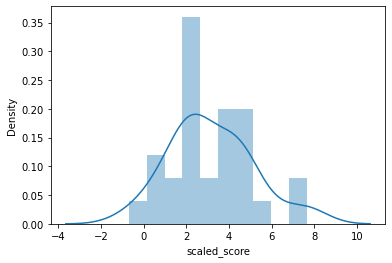

In [131]:
df_scaled['scaled_score'] = df_scaled.apply(set_score, axis=1)
sns.distplot(df_scaled['scaled_score'], bins=10)

C:\Users\Callie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


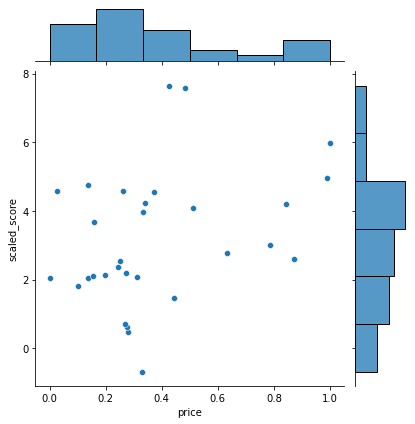

In [132]:
sns.jointplot('price','scaled_score',data=df_scaled)

In [133]:
df['scaled_scores'] = df_scaled['scaled_score']
df.head()

,address,bedrooms,bathrooms,price,squareFootage,floorplan,complex,covered_parking,balcony,washer_dryer,...,longitude,commute_time,grocery_count,bar_count,gas_count,resturant_count,hospital_count,park_count,scores,scaled_scores
0,"5600 Columbia Pike, Falls Church, VA 22041",1,1.0,1837,962,Inspire,Mission Lofts,1.0,0,1,...,-77.123056,19,9,10,14,14,0,14,-1312.0,4.563592
1,"5600 Columbia Pike, Falls Church, VA 22041",2,1.0,2378,1083,Objective,Mission Lofts,1.0,0,1,...,-77.123056,19,9,10,14,14,0,14,-1941.0,4.970088
2,"5600 Columbia Pike, Falls Church, VA 22041",2,2.5,2387,1092,Purpose,Mission Lofts,1.0,0,1,...,-77.123056,19,9,10,14,14,0,14,-1939.5,5.979375
3,"5600 Columbia Pike, Falls Church, VA 22041",1,1.0,1803,720,Aspire,Mission Lofts,1.0,1,1,...,-77.123056,19,9,10,14,14,0,14,-1624.0,3.958125
4,"4501 Ford Ave, Alexandria, VA 22302",1,1.0,1724,632,6C,E-Lofts,1.0,0,1,...,-77.105277,16,8,10,11,14,2,14,-1633.5,2.363894


C:\Users\Callie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


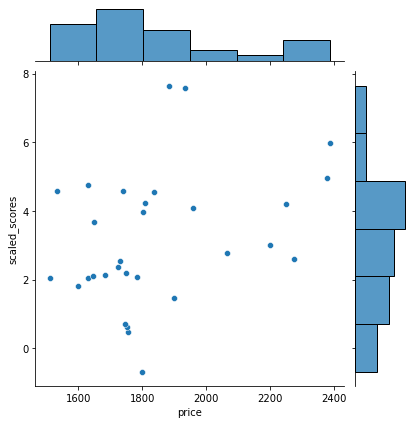

In [134]:
sns.jointplot('price','scaled_scores',data=df)

In [135]:
df_sorted = df.sort_values(by='scaled_scores', ascending= False)
df_sorted.reset_index(drop=True, inplace=True)

df_sorted

,address,bedrooms,bathrooms,price,squareFootage,floorplan,complex,covered_parking,balcony,washer_dryer,...,longitude,commute_time,grocery_count,bar_count,gas_count,resturant_count,hospital_count,park_count,scores,scaled_scores
0,"5000 Eisenhower Ave, Alexandria, VA 22304",2,2.0,1882,1103,Blakely,The Reserve at Eisenhower Apartments,1.0,1,1,...,-77.122900,13,5,5,8,16,0,13,-1154.0,7.647017
1,"5000 Eisenhower Ave, Alexandria, VA 22304",2,2.0,1934,1115,Bingham,The Reserve at Eisenhower Apartments,1.0,1,1,...,-77.122900,13,5,5,8,16,0,13,-1214.0,7.590984
2,"5600 Columbia Pike, Falls Church, VA 22041",2,2.5,2387,1092,Purpose,Mission Lofts,1.0,0,1,...,-77.123056,19,9,10,14,14,0,14,-1939.5,5.979375
3,"5600 Columbia Pike, Falls Church, VA 22041",2,1.0,2378,1083,Objective,Mission Lofts,1.0,0,1,...,-77.123056,19,9,10,14,14,0,14,-1941.0,4.970088
4,"5000 Eisenhower Ave, Alexandria, VA 22304",1,1.0,1631,862,Arrington,The Reserve at Eisenhower Apartments,1.0,1,1,...,-77.122900,13,5,5,8,16,0,13,-1142.0,4.748777
5,"5000 Eisenhower Ave, Alexandria, VA 22304",1,1.0,1534,744,Allison,The Reserve at Eisenhower Apartments,1.0,1,1,...,-77.122900,13,5,5,8,16,0,13,-1173.5,4.591100
6,"5575 Vincent Gate Terrace, Alexandria, VA",1,1.0,1739,1019,C.04,Sullivan Place,1.0,1,1,...,-77.160761,12,0,0,5,4,0,6,-1098.5,4.584252
7,"5600 Columbia Pike, Falls Church, VA 22041",1,1.0,1837,962,Inspire,Mission Lofts,1.0,0,1,...,-77.123056,19,9,10,14,14,0,14,-1312.0,4.563592
8,"6802 Junction Blvd, Springfield, VA 22150",2,2.0,1810,1043,B2,The Residences at Springfield Station,1.0,1,1,...,-77.174331,8,7,15,4,17,1,4,-1134.5,4.240206
9,"6001 Archstone Way, Alexandria, VA 22310",2,2.0,2248,1179,Oak,Park Place at Van Dorn,1.0,1,1,...,-77.139444,15,4,3,10,8,0,3,-1625.0,4.202700


In [136]:
COL = ['price','priceSquareFoot','bedrooms','bathrooms','scaled_scores', 'commute_time']
df_sorted.groupby(['complex']).mean()[COL].sort_values(by='scaled_scores', ascending= False)

,price,priceSquareFoot,bedrooms,bathrooms,scaled_scores,commute_time
complex,,,,,,
The Reserve at Eisenhower Apartments,1745.250000,1.848681,1.500000,1.500000,6.144469,13.0
Mission Lofts,2101.250000,2.198845,1.500000,1.375000,4.867795,19.0
Moderna Tempo,1649.000000,2.389855,1.000000,1.000000,3.672900,16.0
Sullivan Place,1723.000000,1.961245,1.000000,1.000000,2.917225,12.0
The Residences at Springfield Station,1706.428571,2.096176,1.285714,1.285714,2.650616,8.0
E-Lofts,1948.000000,2.356382,1.000000,1.000000,2.568978,16.0
Park Place at Van Dorn,2035.500000,2.042546,1.500000,1.500000,1.999503,15.0
The Shelby,1751.000000,2.370601,1.000000,1.000000,0.600355,21.0
